# Olivine Diffusion - 1
## Introduction to Regression Problems in Geochemistry

*Course: Geochemical Modelling*  
*Duration: 12 hours*  
*Target: Master 2 students*  
(c) Charles Le Losq

---

## Course Overview

This notebook series provides a comprehensive introduction to **regression analysis in geochemistry** using olivine diffusion as a real-world case study. We'll progress from basic fitting to advanced uncertainty quantification.

### **Learning Objectives**

By the end of this notebook series, you should be able to:

1. **Understand the mathematical foundations** of diffusion processes in minerals
2. **Implement regression techniques** using Python and SciPy
3. **Diagnose fitting problems** and understand why optimization can fail
4. **Visualize objective function landscapes** to understand parameter space
5. **Apply advanced optimization strategies** for complex problems
6. **Quantify uncertainties rigorously** using bootstrapping methods
7. **Interpret results** in a geochemical context

### **Course Structure**

- **Notebook 1** (this one): Foundations and first attempts at fitting
- **Notebook 2**: Understanding why fitting fails - objective function analysis
- **Notebook 3**: Advanced techniques and rigorous uncertainty quantification

---

## Geochemical Context

The following methods are applicable to any geochemical model meant to fit data via adjusting its parameters. For this course, we focus on one interesting problem: diffusion in olivine.

Olivine (Mg₂SiO₄) is the most abundant mineral in the Earth's upper mantle, controlling:
- Mantle rheology
- Seismic wave velocities  
- Electrical conductivity
- Volatile element storage and transport

**The Problem:** Despite decades of research, we lack full consensus on how water is stored and diffuses in olivine. One possible mechanism is in association with trivalent cations. Better understanding such mechanism is important for understanding water storage in Earth mantle. The possible mechanisms are:

- Si vacancies ($V_{Si}^{''''} + 4H^{•}$)
- Mg vacancies ($V_{Mg}^{''} + 2H^•$)  
- Associated defects with trivalent cations (Al³⁺, Fe³⁺)
- Ti-clinohumite-like point defects

### **This Course's Dataset**

To better understand the link between trivalent cation concentrations and water in olivine, Le Losq et al. (2019) analyzed diffusions profiles of trivalent cations using Laser Ablation ICP-MS (LA-ICP-MS) and infrared spectroscopy. Results are available in the following paper:

*Le Losq, C., Jollands, M.C., Tollan, P.M.E., Hawkins, R., St. C. O'Neill, H. (2019). Point defect populations of forsterite revealed by two-stage metastable hydroxylation experiments. Contributions to Mineralogy and Petrology, 174, 53.*

Here, **we'll analyze two LA-ICP-MS profiles acquired along the A and C axis of a forsterite crystal.**

This crystal has been prepared at the following conditions:
- Temperature: 1400 °C
- Pressure: 1.5 GPa  
- Duration: 192 hours
- Sample: Forsterite single crystal (1×1×1 mm cube)

---
## Mathematical Foundation: Fick's Diffusion Laws

Diffusion in minerals follows **Fick's laws**. For a constant surface concentration $c_0$ at $x = 0$, the analytical solution is:

$
\begin{align}
c(x,t) = c_0 \cdot \text{erfc}\left(\frac{x}{2\sqrt{Dt}}\right)
\end{align}
$

where:
- $c(x,t)$ = concentration at distance $x$ and time $t$
- $c_0$ = surface concentration (ppm)
- $D$ = diffusion coefficient (m²/s)  
- $x$ = distance from surface (m)
- $t$ = time (s)
- erfc = complementary error function

**Key insight:** This is a **nonlinear regression problem** with parameters $D$ and $c_0$.

### **Exercise 1: Visualize Diffusion Evolution**

Plot concentration profiles at different times to understand the physics before attempting to fit data.

=== Exercise 1: Understanding Diffusion Physics ===
Parameters used:
  Surface concentration: 100.0 ppm
  Diffusion coefficient: 10^-13.1 = 7.94e-14 m²/s
  Temperature: 1400°C (experimental conditions)


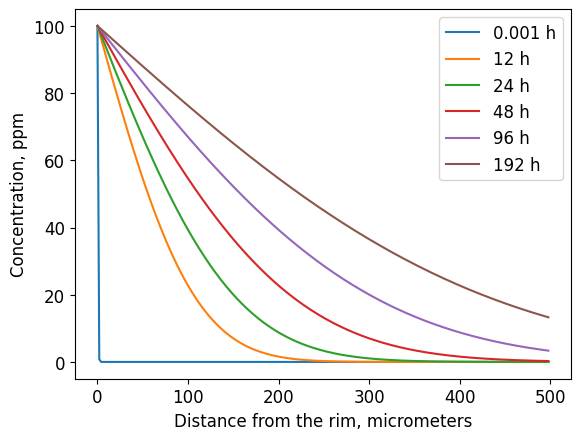


=== Physical Insights ===
Diffusion is a slow process controlled by the relationship:
  Penetration depth ∝ √(D·t)

For our parameters:
  After  12 hours: penetration ≈ 117 μm
  After  48 hours: penetration ≈ 234 μm
  After 192 hours: penetration ≈ 469 μm

=== Key Observations ===
1. Concentration decreases smoothly from rim to core
2. Longer times → deeper penetration
3. The erfc function creates the characteristic 'S-shape'
4. Most change occurs within ~2√(Dt) from the surface

➜ Next: Apply this knowledge to fit real experimental data!


In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42)  # For reproducibility
import pandas as pd
from scipy.optimize import curve_fit
from scipy.special import erfc

# Set plotting parameters for better readability
plt.rcParams.update({'font.size': 12, 'figure.dpi': 100})

def diffusion_1d(x, t, D, c0):
    """
    Analytical solution to 1D Fick's diffusion equation
    
    Parameters
    ----------
    x : float or array_like
        Distance from surface in micrometers
    t : float
        Time in hours
    D : float
        Diffusion coefficient in log₁₀(m² s⁻¹)
    c0 : float
        Surface concentration in ppm
    
    Returns
    -------
    concentration : float or array_like
        Concentration at distance x and time t
        
    Notes
    -----
    This function implements the solution:
    c(x,t) = c₀ * erfc(x / (2*sqrt(D*t)))
    
    The diffusion coefficient D is given in log₁₀ units for convenience,
    as geochemical D values span many orders of magnitude.
    """
    # Avoid t=0 which causes numerical issues
    if np.any(t <= 0):
        t = np.maximum(t, 1e-20)
    
    # Convert units: x from μm to m, t from hours to seconds, D from log to linear
    x_m = x * 1e-6  # μm to m
    t_s = t * 3600  # hours to seconds  
    D_linear = 10**D  # log₁₀ to linear scale
    
    return c0 * erfc(x_m / (2 * np.sqrt(D_linear * t_s)))

# =============================================================================
# Exercise 1: Temporal Evolution of Diffusion Profiles
# =============================================================================

print("=== Exercise 1: Understanding Diffusion Physics ===")

# Define parameters
x_profile = np.arange(0, 500, 2.0)  # Distance profile (μm)
c0_example = 100.0  # Surface concentration (ppm)
D_example = -13.1   # log₁₀(D) typical for water in olivine at 1400°C

print(f"Parameters used:")
print(f"  Surface concentration: {c0_example} ppm")
print(f"  Diffusion coefficient: 10^{D_example} = {10**D_example:.2e} m²/s")
print(f"  Temperature: 1400°C (experimental conditions)")

# Your plotting code here:
times = [0.001, 12, 24, 48, 96, 192]
for t_ in times:
    MY_PROFILE = diffusion_1d(x_profile, t_, D_example, c0_example)
    plt.plot(x_profile, MY_PROFILE, label="{} h".format(t_))
    plt.legend()
    plt.xlabel("Distance from the rim, micrometers")
    plt.ylabel("Concentration, ppm")

plt.show()

# =============================================================================
# Physical insights and scaling relationships
# =============================================================================

print(f"\n=== Physical Insights ===")
print(f"Diffusion is a slow process controlled by the relationship:")
print(f"  Penetration depth ∝ √(D·t)")
print(f"\nFor our parameters:")

for t in [12, 48, 192]:
    penetration = 2 * np.sqrt(10**D_example * t * 3600) * 1e6
    print(f"  After {t:3d} hours: penetration ≈ {penetration:.0f} μm")

print(f"\n=== Key Observations ===")
print(f"1. Concentration decreases smoothly from rim to core")
print(f"2. Longer times → deeper penetration")  
print(f"3. The erfc function creates the characteristic 'S-shape'")
print(f"4. Most change occurs within ~2√(Dt) from the surface")
print(f"\n➜ Next: Apply this knowledge to fit real experimental data!")

## Loading and Understanding Real Experimental Data

Now we transition from theory to practice. Real experimental data always presents challenges that idealized models don't capture.

### **Objectives of this section:**
- Load and visualize LA-ICP-MS diffusion profiles
- Understand data structure and experimental uncertainties
- Identify potential fitting challenges
- Attempt basic curve fitting with `scipy.optimize.curve_fit`

### **Data description:**
- **Sample**: Forsterite single crystal (Mg₂SiO₄)
- **Technique**: Laser Ablation ICP-MS (LA-ICP-MS)
- **Elements**: Fe, Al, Sc, Ti (trace elements)
- **Two orientations**: [100] and [001] (different crystallographic directions)

**Ultimate goals for this course:**
1. ✅ Fit diffusion coefficients for multiple elements
2. ✅ Provide rigorous uncertainty estimates  
3. ✅ Compare results between crystallographic orientations
4. ✅ Interpret results in terms of defect chemistry

**Our approach:** We'll first attempt simple fitting, setting up the need for advanced techniques in subsequent notebooks.

=== Loading LA-ICP-MS Diffusion Profile Data ===
Axis C dataset (parallel to [001] direction):
  Columns: ['ElapsedTime_s', 'Distance', 'Si29_CPS', 'Mg_ppm_m25', 'Al_ppm_m27', 'Sc_ppm_m45', 'Ti_ppm_m47', 'Fe_ppm_m57', 'Re_ppm_m185', 'Pt_ppm_m195']

Axis A dataset (parallel to [100] direction):
  Columns: ['ElapsedTime_s', 'Distance', 'Si29_CPS', 'Mg_ppm_m25', 'Al_ppm_m27', 'Sc_ppm_m45', 'Ti_ppm_m47', 'Fe_ppm_m57', 'Re_ppm_m185', 'Pt_ppm_m195']


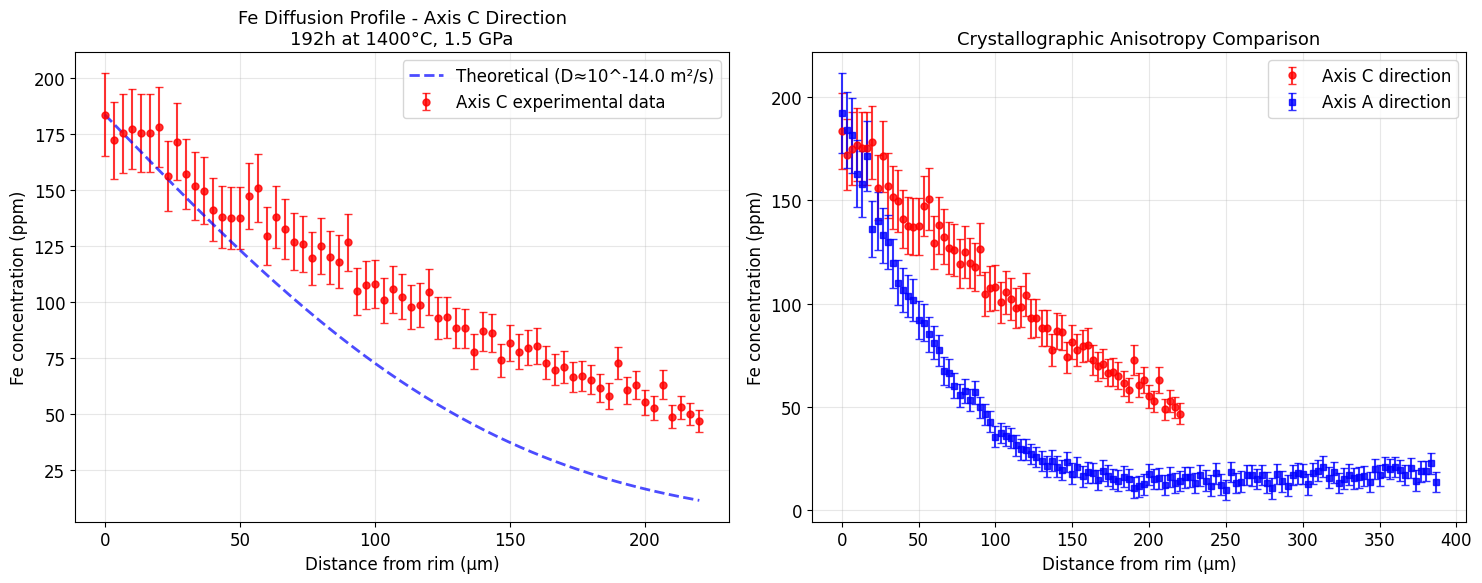


=== Initial Data Analysis ===
Profile characteristics (Axis C):
  Surface concentration: 183.5 ppm
  Background concentration: 46.7 ppm
  Rough D estimate: ~10^-14.3 m²/s

=== Key Observations ===
✓ Data show expected diffusion behavior (high→low concentration)
✓ Crystallographic anisotropy is evident ([100] ≠ [001])
⚠ Scatter in data suggests measurement uncertainties
⚠ Limited data points for robust fitting
⚠ Background concentration is not zero (core composition)

➜ Challenge: How to fit these noisy, limited data robustly?


In [5]:
# =============================================================================
# Loading and Exploring Experimental Data
# =============================================================================

print("=== Loading LA-ICP-MS Diffusion Profile Data ===")

# Load experimental datasets
data_AxisC = pd.read_csv("./data/16C_ICP1_1400C_axisC_192h_FoEn.csv")
data_AxisA = pd.read_csv("./data/16C_ICP2_1400C_axisA_192h_FoEn.csv")

print("Axis C dataset (parallel to [001] direction):")
print(f"  Columns: {data_AxisC.columns.tolist()}")

print(f"\nAxis A dataset (parallel to [100] direction):")
print(f"  Columns: {data_AxisA.columns.tolist()}")

# =============================================================================
# Uncertainties
#
# We adopt a simplified approach here: 10 % uncertainties, or, if lower than
# 5 ppm, then 5 ppm
# =============================================================================

x_AxisC = data_AxisC.Distance
Fe_AxisC = data_AxisC.Fe_ppm_m57

x_AxisA = data_AxisA.Distance
Fe_AxisA = data_AxisA.Fe_ppm_m57

# Use: max(10% of concentration, 5 ppm minimum)
Fe_error_AxisC = np.maximum(0.1 * Fe_AxisC, 5.0)
Fe_error_AxisA = np.maximum(0.1 * Fe_AxisA, 5.0)

# =============================================================================
# Data Visualization
# =============================================================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Panel 1: Axis C profile with error bars
ax1.errorbar(x_AxisC, Fe_AxisC, yerr=Fe_error_AxisC, 
             fmt='o', color='red', capsize=3, capthick=1, markersize=5,
             label="Axis C experimental data", alpha=0.8)

ax1.set_xlabel("Distance from rim (μm)", fontsize=12)
ax1.set_ylabel("Fe concentration (ppm)", fontsize=12)
ax1.set_title("Fe Diffusion Profile - Axis C Direction\n192h at 1400°C, 1.5 GPa", fontsize=13)
ax1.grid(True, alpha=0.3)
ax1.legend()

# Add theoretical profile for comparison (using typical D value)
D_initial_guess = -14.0  # log₁₀(m²/s) - initial estimate
c0_initial_guess = np.max(Fe_AxisC)  # Use maximum concentration as c0 estimate
t_experiment = 192.0  # hours

x_theory = np.linspace(0, np.max(x_AxisC), 200)
Fe_theory = diffusion_1d(x_theory, t_experiment, D_initial_guess, c0_initial_guess)

ax1.plot(x_theory, Fe_theory, '--', color='blue', linewidth=2, alpha=0.7,
         label=f"Theoretical (D≈10^{D_initial_guess} m²/s)")
ax1.legend()

# Panel 2: Both orientations comparison
ax2.errorbar(x_AxisC, Fe_AxisC, yerr=Fe_error_AxisC,
             fmt='o', color='red', capsize=3, capthick=1, markersize=5,
             label="Axis C direction", alpha=0.8)

ax2.errorbar(x_AxisA, Fe_AxisA, yerr=Fe_error_AxisA,
             fmt='s', color='blue', capsize=3, capthick=1, markersize=5,
             label="Axis A direction", alpha=0.8)

ax2.set_xlabel("Distance from rim (μm)", fontsize=12)
ax2.set_ylabel("Fe concentration (ppm)", fontsize=12)
ax2.set_title("Crystallographic Anisotropy Comparison", fontsize=13)
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# =============================================================================
# Initial Observations and Challenges
# =============================================================================

print(f"\n=== Initial Data Analysis ===")

print(f"Profile characteristics (Axis C):")
print(f"  Surface concentration: {np.max(Fe_AxisC):.1f} ppm")
print(f"  Background concentration: {np.min(Fe_AxisC):.1f} ppm")

# Rough diffusion coefficient estimate using penetration depth
# Using approximation: penetration ≈ 2*sqrt(D*t) for erfc profile
# you look on the graph above, set the distance_where_half_max value
# to the observed value, then you can calculate an estimate of D
distance_where_half_max = 120
D_rough_estimate = np.log10((distance_where_half_max * 1e-6)**2 / (4 * t_experiment * 3600))
print(f"  Rough D estimate: ~10^{D_rough_estimate:.1f} m²/s")

print(f"\n=== Key Observations ===")
print(f"✓ Data show expected diffusion behavior (high→low concentration)")
print(f"✓ Crystallographic anisotropy is evident ([100] ≠ [001])")
print(f"⚠ Scatter in data suggests measurement uncertainties")
print(f"⚠ Limited data points for robust fitting")
print(f"⚠ Background concentration is not zero (core composition)")
print(f"\n➜ Challenge: How to fit these noisy, limited data robustly?")

## First Attempt at Curve Fitting

Now let's attempt to fit our theoretical diffusion model to the experimental data using `scipy.optimize.curve_fit`, the standard tool for nonlinear regression in Python.

### **The Regression Problem**


The general idea is to define a model *m* which fits our data *d* with some parameters we can tune. We basically want to map:

$
\begin{align}
d = g(m)
\end{align}
$

with $g$ the mapping function and $m$ the model (set of model parameters).

In our case, we want to find the best values of $D$ and $c_0$ (and potentially a background concentration $c_{bg}$) that minimize the difference between our model and the data.

**Modified forward model for realistic data:**

$
\begin{align}
c(x,t) = (c_0 - c_{bg}) \cdot \text{erfc}\left(\frac{x}{2\sqrt{Dt}}\right) + c_{bg}
\end{align}
$

**Parameters to fit:**
- $D$: diffusion coefficient (log₁₀ m²/s)  
- $c_0$: rim concentration (ppm)
- $c_{bg}$: background/core concentration (ppm)
 In this case, $g$ is the equation 2 and $m$ are the $D$, $c0$ and $c_{bg}$ parameters.

**Least-square regression**

An easy and well used way to fit our data with eq. 2 is to use least-square regression. The least-square problem consists in minimizing the misfit between the observation $d$ and the model predictions $g(m)$:

$
\begin{align}
misfit = \sum_{i=1}^{n}{(d_i-g_i(m))^2}
\end{align}
$

We want to minimize this value. Eq. 4 is called the **objective function** or **misfit function** of our problem. Eq. 4 is a least-square objective function. Other functions can be used, like the least absolute value objective function (a.k.a. L1 norm).

There is several way to do that. In Python, one of the simplest is to **use the curve_fit function of scipy**. In order to use this function, we need to have another one that allows calculating eq. 3. Let's do that.

### **Why might fitting fail?**

Before we start, let's consider potential challenges:
1. **Parameter scaling**: $D$ values span many orders of magnitude
2. **Parameter correlation**: $D$, $c_0$, and $c_{bg}$ may be correlated
3. **Initial guesses**: Nonlinear optimization needs good starting points
4. **Local minima**: The objective function may have complex topology
5. **Data quality**: Limited points, measurement errors, outliers

Let's see what happens with a naive approach...

In [7]:
# =============================================================================
# Defining the Forward Model for Fitting
# =============================================================================

def forward_model_3param(x, D, c_rim, c_bg):
    """
    Three-parameter diffusion model for fitting experimental data
    
    This is our forward model: the function that predicts concentrations
    given parameter values and distance measurements.
    
    Parameters
    ----------
    x : array_like
        Distance from rim in micrometers
    D : float
        Diffusion coefficient in log10(m^2 s^-1)
    c_rim : float
        Rim concentration in ppm
    c_bg : float
        Background/core concentration in ppm
        
    Returns
    -------
    concentration : array_like
        Predicted concentration at each distance x
    """

    # here you need to manually set t_exp
    t_exp = 192.0 * 3600  # Experimental duration in seconds

    # convertions
    x_m = x * 1e-6  # Convert μm to m
    D_linear = 10**D  # Convert log scale to linear
    
    # Modified erfc solution with background
    return (c_rim - c_bg) * erfc(x_m / (2 * np.sqrt(D_linear * t_exp))) + c_bg

# =============================================================================
# Attempt 1: Naive Fitting (may fail!)
# =============================================================================

print("=== Attempt 1: Naive curve_fit (default settings) ===")

# Using curve_fit with default initial guesses (all parameters = 1.0)
# This may fail or lead to bad parameter estimates
popt_naive, pcov_naive = curve_fit(forward_model_3param, 
                                    x_AxisC, 
                                    Fe_AxisC)

print("Naive fitting succeeded (surprisingly!):")
print(f"  D = {popt_naive[0]:.2f} (log₁₀ m²/s)")
print(f"  c_rim = {popt_naive[1]:.1f} ppm")
print(f"  c_bg = {popt_naive[2]:.1f} ppm")
    
# =============================================================================
# Attempt 2: Smart Initial Guesses
# =============================================================================

print(f"\n=== Attempt 2: Intelligent Parameter Initialization ===")

# Set initial guesses based on data inspection
D_init = -14.0  # Typical for Fe in olivine at 1400 °C
c_rim_init = np.max(Fe_AxisC)  # Maximum concentration
c_bg_init = np.min(Fe_AxisC)   # Minimum concentration

initial_guesses = [D_init, c_rim_init, c_bg_init]

popt_smart, pcov_smart = curve_fit(forward_model_3param, 
                                    x_AxisC, Fe_AxisC, 
                                    p0=initial_guesses,
                                    sigma=Fe_error_AxisC,  # Include uncertainties
                                    absolute_sigma=True)
    
print(f"\nSmart fitting results:")
print(f"  D = {popt_smart[0]:.3f} ± {np.sqrt(pcov_smart[0,0]):.3f} (log₁₀ m²/s)")
print(f"  c_rim = {popt_smart[1]:.1f} ± {np.sqrt(pcov_smart[1,1]):.1f} ppm")
print(f"  c_bg = {popt_smart[2]:.1f} ± {np.sqrt(pcov_smart[2,2]):.1f} ppm")


=== Attempt 1: Naive curve_fit (default settings) ===
Naive fitting succeeded (surprisingly!):
  D = -13.72 (log₁₀ m²/s)
  c_rim = 181.7 ppm
  c_bg = 23.3 ppm

=== Attempt 2: Intelligent Parameter Initialization ===

Smart fitting results:
  D = -13.673 ± 0.128 (log₁₀ m²/s)
  c_rim = 179.9 ± 5.0 ppm
  c_bg = 17.1 ± 14.6 ppm


## Understanding Chi-Square Statistics for Fit Quality Assessment

Before analyzing our fitting results, let's understand the **chi-square (χ²) statistics** that quantify how well our model matches the data.

### **Chi-Square ($\chi^2$) Statistic:**

The chi-square statistic measures the weighted sum of squared residuals:

$$\chi^2 = \sum_{i=1}^{n} \left(\frac{y_i - f(x_i, \theta)}{\sigma_i}\right)^2$$

where:
- $y_i$ = observed data point
- $f(x_i, \theta)$ = model prediction at $x_i$ with parameters $\theta$
- $\sigma_i$ = uncertainty (error bar) for data point $i$
- $n$ = number of data points

### **Reduced Chi-Square ($\chi^2_\nu$):**

The reduced chi-square normalizes by degrees of freedom:

$$\chi^2_\nu = \frac{\chi^2}{\nu} = \frac{\chi^2}{n - p}$$

where:
- $\nu$ = degrees of freedom = $n - p$
- $p$ = number of fitted parameters

### **Interpretation Guidelines:**

**For a good fit with properly estimated uncertainties:**
- **$\chi^2_\nu$ ≈ 1** -> residuals are consistent with estimated errors;
- **$\chi^2_\nu$ << 1** -> Either over-fitting or overestimated uncertainties;
- **$\chi^2_\nu$ >> 1** -> Either poor model fit or underestimated uncertainties;

### **Practical Thresholds:**
- **$\chi^2_\nu$ < 0.5**: Suspicious - check error estimates
- **0.5 ≤ $\chi^2_\nu$ ≤ 2.0**: Acceptable fit quality
- **$\chi^2_\nu$ > 2.0**: Poor fit - model or error issues

### **Why This is Important:**
- **Validates analytical uncertainties**: Are our error bars realistic?
- **Guides model selection**: Is our model appropriate?
- **Informs experimental design**: What precision do we need?
- **Quality control**: Identifies outliers or systematic problems

In [ ]:
# =============================================================================
# EXERCISE: Visualization and Statistical Analysis
# =============================================================================

# TODO: Create detailed visualization with two panels
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Panel 1: Data and fit
# Plot experimental data with error bars
# Plot fitted model (use fine x grid for smooth curve)
# Add your code here:



# Panel 2: Residuals analysis
# Calculate residuals: data - model
# Plot residuals with error bars
# Add reference lines (y=0, ±1σ)
# Add your code here:
residuals = 



plt.tight_layout()
plt.show()

# TODO: Statistical analysis
print(f"\n=== Statistical Analysis ===")
print(f"Residual statistics:")
# Print mean, std, max absolute residual
# Add your code here:


# TODO: Chi-square analysis
# Calculate chi-square and reduced chi-square
# Interpret the results
# Compelte the code here:
chi_squared = 
degrees_of_freedom = 
reduced_chi_squared = 

print(f"  χ² = {chi_squared:.1f} (sum of weighted squared residuals)")
print(f"  Degrees of freedom = {degrees_of_freedom} ({len(Fe_AxisC)} points - 3 parameters)")
print(f"  Reduced χ² = {reduced_chi_squared:.2f}")


## Creating Synthetic Data for Method Development

Before tackling the challenges with real data, let's create synthetic (artificial) data where we know the "true" parameters. This allows us to:

1. **Test our fitting algorithms** under controlled conditions
2. **Understand the effects of noise** on parameter recovery
3. **Validate our approach** before applying it to real data
4. **Explore the parameter space** systematically

### **Why playing with synthetic data matters:**
- **Method validation**: Prove algorithms work before applying to expensive experimental data
- **Error analysis**: Understand how measurement uncertainties propagate to parameter uncertainties
- **Experimental design**: Optimize sampling strategies and analytical protocols
- **Hypothesis testing**: Test whether proposed models can explain observations

This approach is standard practice in computational geochemistry and geophysics.

In [ ]:
# =============================================================================
# EXERCISE: Generate Synthetic Data
# =============================================================================

print("=== Generating Synthetic Diffusion Data ===")

# TODO: Define "true" parameters (what we want to recover)
D_true = -14.5          # log₁₀(m²/s)
c_rim_true = 95.0       # ppm
c_bg_true = 8.0         # ppm

print(f"True parameters (what we want to recover):")
print(f"  D_true = {D_true} (log₁₀ m²/s)")  
print(f"  c_rim_true = {c_rim_true} ppm")
print(f"  c_bg_true = {c_bg_true} ppm")

# TODO: Create synthetic measurement locations
# Use np.arange(0, 120, 3.0) for every 3 μm from 0 to 120 μm
x_synthetic = 

# TODO: Generate perfect synthetic data
y_synthetic_perfect = 

# TODO: Add realistic noise
# Set noise level
# 5 ppm or 10 % if higher
# Add Gaussian noise with np.random.normal()
# Create variable error bars
np.random.seed(42)  # For reproducible results
noise_level = 5.0
# Your noise code here:
noise = 
y_synthetic_noisy = 
error_synthetic = 

print(f"  Noise level: {noise_level} ppm (1σ)")
print(f"  Signal-to-noise ratio: {np.max(y_synthetic_perfect)/noise_level:.1f}")

In [ ]:
# =============================================================================
# EXERCISE: Fit Synthetic Data
# =============================================================================

print(f"\n=== Fitting Synthetic Data (Should Work Well) ===")

# TODO: Create initial guesses (slightly off from true values)
D_init_syn = -14.0      # Close but not exact
c_rim_init_syn = 100.0  # Close but not exact  
c_bg_init_syn = 5.0     # Close but not exact

initial_guesses_syn = [D_init_syn, c_rim_init_syn, c_bg_init_syn]

# TODO: Fit the synthetic data

# Use curve_fit with synthetic data and initial guesses
# Your fitting code here:
popt_syn, pcov_syn = 

# TODO: Calculate parameter uncertainties and recovery errors
param_errors_syn = 

print(f"Fitting results:")
print(f"  D = {popt_syn[0]:.3f} ± {param_errors_syn[0]:.3f} (true: {D_true})")
print(f"  c_rim = {popt_syn[1]:.1f} ± {param_errors_syn[1]:.1f} (true: {c_rim_true})")  
print(f"  c_bg = {popt_syn[2]:.1f} ± {param_errors_syn[2]:.1f} (true: {c_bg_true})")

# TODO: Check parameter recovery (how close are we to true values?)
# Your recovery analysis here:



In [ ]:
# =============================================================================
# EXERCISE: Visualize Synthetic Results
# =============================================================================

# TODO: Create a 2x2 subplot figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Panel 1: Synthetic data and fit
# Show: noisy data, perfect model, fitted model
# Your plotting code here:


# Panel 2: Residuals for synthetic data
# Show residuals with error bars and reference lines
# Your residuals code here:


# Panel 3: Parameter correlation matrix
# Calculate and visualize correlation matrix
# Your correlation code here:
correlation_matrix = 


# Panel 4: Real vs synthetic comparison
# Compare real and synthetic fitting results
# Your comparison code here:


plt.tight_layout()
plt.show()

## Summary and Preview of Advanced Techniques

### **What we've learned in Notebook 1:**

1. **✅ Theoretical foundation**: Fick's diffusion equation and its analytical solution
2. **✅ Real data challenges**: Experimental uncertainties, limited sampling, background concentrations  
3. **✅ Basic regression**: Using `scipy.optimize.curve_fit` for nonlinear fitting
4. **✅ Parameter initialization**: The critical importance of good starting guesses
5. **✅ Method validation**: Using synthetic data to test algorithms
6. **✅ Statistical analysis**: Residuals, correlation matrices, goodness-of-fit metrics

### **Key challenges identified:**

- **Parameter scaling**: Diffusion coefficients span many orders of magnitude
- **Parameter correlation**: D, c_rim, and c_bg are often strongly correlated
- **Local minima**: Nonlinear optimization can get trapped in suboptimal solutions
- **Uncertainty quantification**: How reliable are the error bars from curve_fit?

### **What's coming next:**

**Notebook 2: Understanding Optimization Landscapes**
- Visualize the objective function in parameter space
- Understand why local algorithms fail
- Compare least squares vs. least absolute deviations
- Explore global optimization strategies

**Notebook 3: Rigorous Uncertainty Quantification**  
- Limitations of covariance-based uncertainties
- Bootstrap methods for robust error estimation
- Confidence intervals for predictions
- Real-world application to multiple elements

---

### **The Bigger Picture: Why This Matters in Geochemistry**

Robust parameter estimation is crucial for:
- **Process understanding**: Inferring diffusion mechanisms and defect chemistry
- **Extrapolation**: Predicting behavior at different T-P-t conditions
- **Comparison**: Benchmarking experimental results across studies
- **Modeling**: Parameterizing large-scale geodynamic models

The techniques we're developing apply broadly to:
- Kinetic experiments (diffusion, dissolution, crystallization)
- Thermobarometry and geothermometry
- Isotope systematics and geochronology
- Spectroscopic analysis and calibration

In [6]:
# =============================================================================
# Exercises for Students
# =============================================================================

print("=== EXERCISES FOR STUDENTS ===")
print("\nTry these exercises to deepen your understanding:")

print("\n1. PARAMETER SENSITIVITY ANALYSIS")
print("   Modify the true parameters in the synthetic data generation:")
print("   - Try D_true = -15.0 (slower diffusion)")
print("   - Try D_true = -13.0 (faster diffusion)")  
print("   - How does this affect fitting success and parameter uncertainties?")

print("\n2. NOISE LEVEL INVESTIGATION")
print("   Change the noise_level parameter:")
print("   - Try noise_level = 2.0 (better precision)")
print("   - Try noise_level = 10.0 (worse precision)")
print("   - How does measurement precision affect parameter recovery?")

print("\n3. SAMPLING DENSITY EXPERIMENT")  
print("   Modify the synthetic data spacing:")
print("   - Try x_synthetic = np.arange(0, 120, 6.0)  # Fewer points")
print("   - Try x_synthetic = np.arange(0, 120, 1.5)  # More points")
print("   - What's the minimum sampling needed for robust fitting?")

print("\n4. ALTERNATIVE ELEMENTS")
print("   Try fitting other elements from the dataset:")
print("   - Al_ppm_m27 (aluminum)")  
print("   - Ti_ppm_m49 (titanium)")
print("   - How do diffusion coefficients compare between elements?")

print("\n5. CRYSTALLOGRAPHIC ANISOTROPY")
print("   Compare fitting results between Axis A and Axis C orientations:")
print("   - Fit the same element in both directions")
print("   - Calculate the anisotropy ratio: D_AxisC / D_AxisA")
print("   - Which direction shows faster diffusion?")

# =============================================================================
# Template Code for Student Exercises
# =============================================================================

print(f"\n=== TEMPLATE CODE FOR EXERCISE 4 ===")
print("# Try fitting aluminum instead of iron:")
print("# Al_FoEn = data_FoEn['Al_ppm_m27'].values")
print("# Al_error_FoEn = np.maximum(0.1 * Al_FoEn, 2.0)")
print("# ")
print("# popt_Al, pcov_Al = curve_fit(forward_model_3param,")  
print("#                              x_FoEn, Al_FoEn,")
print("#                              p0=[-14.0, np.max(Al_FoEn), np.min(Al_FoEn)],")
print("#                              sigma=Al_error_FoEn,")
print("#                              absolute_sigma=True)")


=== EXERCISES FOR STUDENTS ===

Try these exercises to deepen your understanding:

1. PARAMETER SENSITIVITY ANALYSIS
   Modify the true parameters in the synthetic data generation:
   - Try D_true = -15.0 (slower diffusion)
   - Try D_true = -13.0 (faster diffusion)
   - How does this affect fitting success and parameter uncertainties?

2. NOISE LEVEL INVESTIGATION
   Change the noise_level parameter:
   - Try noise_level = 2.0 (better precision)
   - Try noise_level = 10.0 (worse precision)
   - How does measurement precision affect parameter recovery?

3. SAMPLING DENSITY EXPERIMENT
   Modify the synthetic data spacing:
   - Try x_synthetic = np.arange(0, 120, 6.0)  # Fewer points
   - Try x_synthetic = np.arange(0, 120, 1.5)  # More points
   - What's the minimum sampling needed for robust fitting?

4. ALTERNATIVE ELEMENTS
   Try fitting other elements from the dataset:
   - Al_ppm_m27 (aluminum)
   - Ti_ppm_m49 (titanium)
   - How do diffusion coefficients compare between elements?

## Additional Resources and References

### **Essential Python Libraries for Geochemical Data Analysis**

- **SciPy**: `scipy.optimize` for fitting, `scipy.stats` for statistics
- **NumPy**: Numerical computing foundation
- **Matplotlib**: Publication-quality plotting
- **Pandas**: Data manipulation and analysis
- **Uncertainties**: Error propagation (we'll use this in Notebook 3)
- **lmfit**: Advanced fitting with parameter constraints
- **emcee**: Markov Chain Monte Carlo for Bayesian analysis

### **Key References**

**Diffusion in Olivine:**
- Demouchy, S., & Bolfan-Casanova, N. (2016). Distribution and transport of hydrogen in the lithospheric mantle: A review. *Lithos*, 240–243, 402–425.

- Jollands, M. C., et al. (2019). Coupled inter-site reaction and diffusion: Rapid dehydrogenation of silicon vacancies in natural olivine. *Geochimica et Cosmochimica Acta*, 262, 220-242.

- Le Losq, C., Jollands, M.C., Tollan, P.M.E., Hawkins, R., St. C. O'Neill, H. (2019). Point defect populations of forsterite revealed by two-stage metastable hydroxylation experiments. *Contributions to Mineralogy and Petrology*, 174, 53.

**Regression Theory and Statistical Methods:**
- Tarantola, A. (2005) *Inverse problem theory and methods for model parameter estimation*. Society for Industrial and Applied Mathematics, Philadelphia, PA. 342 p.

- Bevington, P.R., and Robinson, D.K. (2003). *Data reduction and error analysis for the physical sciences*, 3. ed., McGraw-Hill, Boston, Mass. 320 p.

### **Online Resources**

- **SciPy Documentation**: https://docs.scipy.org/doc/scipy/reference/optimize.html
- **Python for Geosciences**: https://github.com/valentineap/ComputationalGeoscienceCourse

### **Software Alternatives**

While this course uses Python, similar analyses can be performed with:
- **R**: Excellent statistical packages, `nls()` function for nonlinear fitting
- **MATLAB**: `lsqcurvefit()` and Optimization Toolbox
- **Origin**: User-friendly interface for curve fitting
- **Igor Pro**: Popular in analytical geochemistry
- **Mathematica**: Symbolic and numerical computing

---